This competition has seen very good results with Google's masterpiece EfficientNet. But I am exploring the other networks' baseline capabilities like Densenet, Inception, InceptionResnet, Resnet101, Resnet152 and other variations.

In [1]:
import numpy as np 
import pandas as pd 
import os

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import (Input, MaxPooling2D, BatchNormalization,
                                    GlobalAveragePooling2D, Dense, Conv2D,
                                    Dropout, Flatten, Activation, ZeroPadding2D,
                                    Add)
from tensorflow.keras import activations
from tensorflow.keras.models import Model

from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
from kaggle_datasets import KaggleDatasets

import matplotlib.pyplot as plt
%matplotlib inline
import gc
import tempfile

In [2]:
from keras import layers
from keras import models

In [3]:
def auto_select_accelerator():
    
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy


def build_decoder(with_labels=True, target_size=(600,600), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")
        
        img = tf.cast(img, tf.float32) / 255.0
        
        img = tf.image.resize(img,target_size, 
                              method=tf.image.ResizeMethod.MITCHELLCUBIC,
                              antialias=True)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.70, 1.30)
        img = tf.image.random_contrast(img, 0.80, 1.20)
        img = tf.image.random_brightness(img, 0.10)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, bsize=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset

In [4]:
COMPETITION_NAME = "ranzcr-clip-catheter-line-classification"
strategy = auto_select_accelerator()
BATCH_SIZE = strategy.num_replicas_in_sync * 16
GCS_DS_PATH = KaggleDatasets().get_gcs_path(COMPETITION_NAME)

Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas


In [5]:
load_dir = f"/kaggle/input/{COMPETITION_NAME}/"
df = pd.read_csv(load_dir + 'train.csv')

# paths = load_dir + "train/" + df['StudyInstanceUID'] + '.jpg'
paths = GCS_DS_PATH + "/train/" + df['StudyInstanceUID'] + '.jpg'

sub_df = pd.read_csv(load_dir + 'sample_submission.csv')

# test_paths = load_dir + "test/" + sub_df['StudyInstanceUID'] + '.jpg'
test_paths = GCS_DS_PATH + "/test/" + sub_df['StudyInstanceUID'] + '.jpg'

# Get the multi-labels
label_cols = sub_df.columns[1:]
labels = df[label_cols].values

In [6]:
(
    train_paths, valid_paths, 
    train_labels, valid_labels
) = train_test_split(paths, labels, test_size=0.2, random_state=42)

In [7]:
im_size = 600

decoder = build_decoder(with_labels=True, target_size=(im_size, im_size))
test_decoder = build_decoder(with_labels=False, target_size=(im_size, im_size))

train_dataset = build_dataset(
    train_paths, train_labels, bsize=BATCH_SIZE, decode_fn=decoder
)

valid_dataset = build_dataset(
    valid_paths, valid_labels, bsize=BATCH_SIZE, decode_fn=decoder,
    repeat=False, shuffle=False, augment=False
)

test_dataset = build_dataset(
    test_paths, cache=False, bsize=BATCH_SIZE, decode_fn=test_decoder,
    repeat=False, shuffle=False, augment=False
)

In [8]:
n_labels = labels.shape[1]

In [10]:
with strategy.scope():
    
    inputs = tf.keras.Input(shape=(600,600, 3))
    x = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet', input_shape=(600,600,3))(inputs)
    #x = tf.keras.layers.GaussianNoise(1)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(11,activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs, outputs)
  
    '''inception_layers = model.get_layer('inception_v3').layers
    for i in range(len(inception_layers)):
        l_name = inception_layers[i].name
        if l_name == 'mixed0':
            idx = i
            break
            
    for j in range(len(inception_layers)):
        if j>idx:
            model.get_layer('inception_v3').layers[j].trainable = True
        else:
            model.get_layer('inception_v3').layers[j].trainable = False'''
            

    def add_regularization(model, regularizer=tf.keras.regularizers.L2(0.0001)):

        if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
          print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
          return model

        for layer in model.layers:
            for attr in ['kernel_regularizer']:
                if hasattr(layer, attr):
                  setattr(layer, attr, regularizer)
            for attr in ['bias_regularizer']:
                if hasattr(layer, attr):
                  setattr(layer, attr, regularizer)
                
    
    # When we change the layers attributes, the change only happens in the model config file
        model_json = model.to_json()

    # Save the weights before reloading the model.
        tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
        model.save_weights(tmp_weights_path)

    # load the model from the config
        model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
        model.load_weights(tmp_weights_path, by_name=True)
        return model
    
    model = add_regularization(model)
        
model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 17, 17, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                22539     
Total params: 21,825,323
Trainable params: 21,790,891
Non-trainable params: 34,432
_________________________________________________________________


In [11]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc',multi_label=True)])

In [12]:
steps_per_epoch = train_paths.shape[0] // BATCH_SIZE
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model2.h5', save_best_only=True, monitor='val_auc', mode='max')
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc", patience=3, min_lr=1e-6, mode='max')

print("Batch size: {}".format(BATCH_SIZE))
print("Steps per epoch: {}".format(steps_per_epoch))

Batch size: 128
Steps per epoch: 188


In [13]:
history = model.fit(
    train_dataset, 
    epochs=30,
    callbacks=[checkpoint, lr_reducer],
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_dataset)

Epoch 1/30
188/188 [==============================] - 1235s 6s/step - loss: 0.2572 - auc: 0.7595 - val_loss: 0.3090 - val_auc: 0.7372
Epoch 2/30
188/188 [==============================] - 147s 781ms/step - loss: 0.1996 - auc: 0.8581 - val_loss: 0.2563 - val_auc: 0.8392
Epoch 3/30
188/188 [==============================] - 144s 768ms/step - loss: 0.1821 - auc: 0.8924 - val_loss: 0.1853 - val_auc: 0.8950
Epoch 4/30
188/188 [==============================] - 140s 748ms/step - loss: 0.1723 - auc: 0.9022 - val_loss: 0.1772 - val_auc: 0.8964
Epoch 5/30
188/188 [==============================] - 131s 695ms/step - loss: 0.1646 - auc: 0.9115 - val_loss: 0.2207 - val_auc: 0.8643
Epoch 6/30
188/188 [==============================] - 131s 695ms/step - loss: 0.1590 - auc: 0.9237 - val_loss: 0.1870 - val_auc: 0.9104
Epoch 7/30
188/188 [==============================] - 130s 691ms/step - loss: 0.1537 - auc: 0.9249 - val_loss: 0.1708 - val_auc: 0.9134
Epoch 8/30
188/188 [==============================

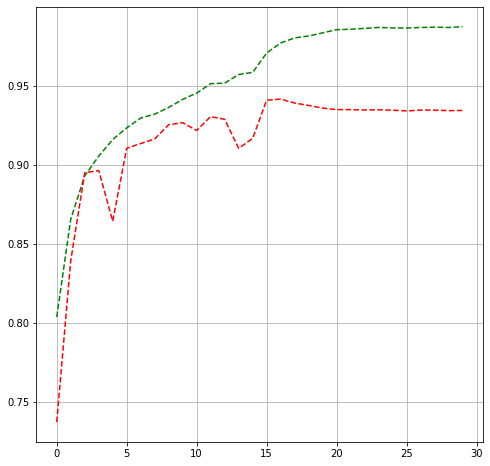

In [14]:
plt.figure(figsize=(8,8))
plt.grid()
plt.plot(history.history['auc'],'g--')
plt.plot(history.history['val_auc'],'r--')

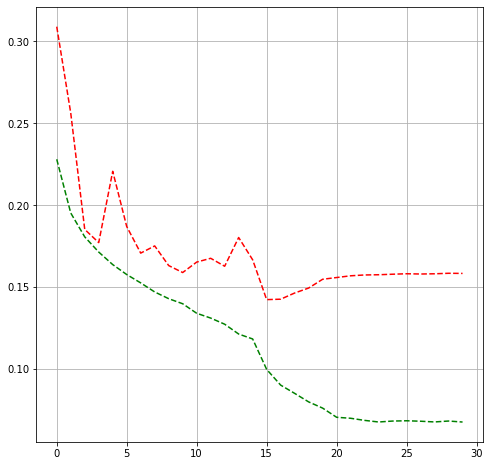

In [15]:
plt.figure(figsize=(8,8))
plt.grid()
plt.plot(history.history['loss'],'g--')
plt.plot(history.history['val_loss'],'r--')

In [17]:
model_name = "L1_L2_Regularised_InceptionV3.h5"
model.save(model_name)